In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers.experimental.preprocessing import RandomTranslation, RandomRotation
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import random
%matplotlib inline

In [2]:
#stworzenie zbioru treningowego
#stworzone są listy obrazów i 'label', obrazy przeskalowane do wartości pikseli [0,1]
#następnie obie listy są pomieszane i połowy są łączone w zbiór treningowy przy użyciu np.concatenate()

data = []
label = []
categories = []

for i, folder in enumerate(os.listdir('rps')):
    y = np.zeros(3)
    y[i] = 1
    categories.append([i,folder])
    for file in os.listdir('rps/'+folder):
        data.append((np.array(Image.open('rps/'+folder+'/'+file).convert('RGB'))))
        label.append(y)
        
data = np.array(data,dtype=np.float32)/255.
label = np.array(label)

data, label = shuffle(data, label)
data, label = shuffle(data, label)
data, label = shuffle(data, label)
data, label = shuffle(data, label)

n = data.shape[0]
data = np.concatenate((data[0:n//2],data[n//2:n]),axis=2)
label = np.concatenate((label[0:n//2],label[n//2:n]),axis=1)

[1. 0. 0. 0. 1. 0.]


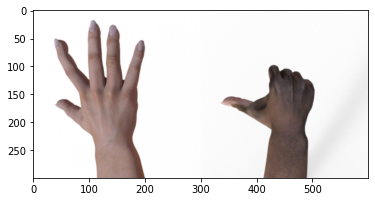

In [3]:
print(label[25])
plt.imshow(data[25])

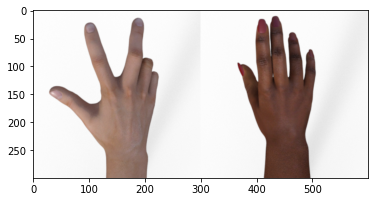

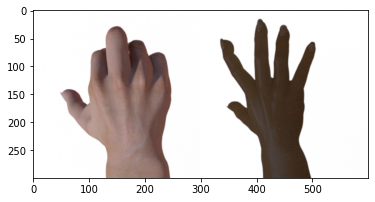

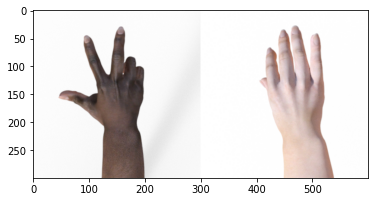

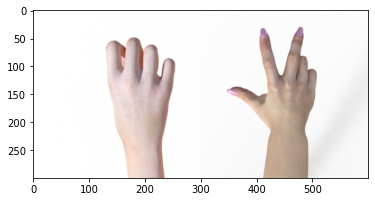

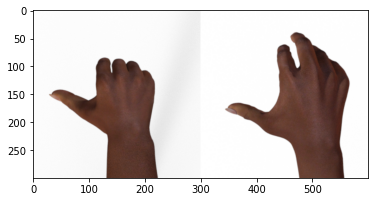

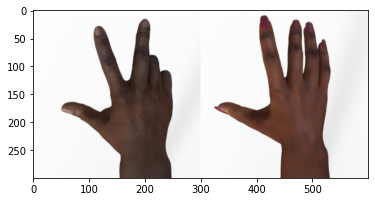

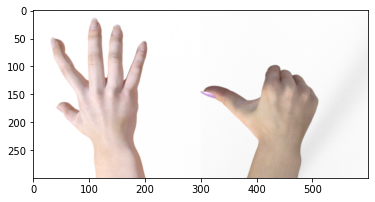

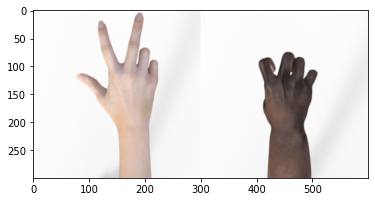

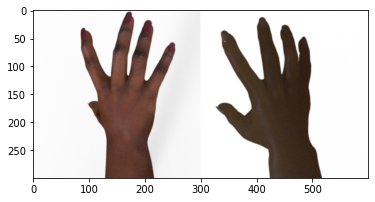

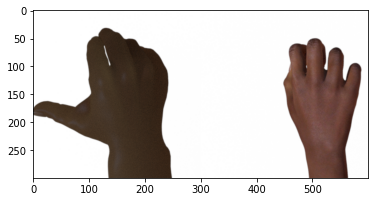

In [4]:
for i in range(10):
    plt.imshow(data[i])
    plt.show()

In [5]:
#stworzenie zbioru testowego

tdata=[]
tlabel=[]

for i, folder in enumerate(os.listdir('rps-test-set')):
    y=np.zeros(3)
    y[i]=1
    for file in os.listdir('rps-test-set/'+folder):
        tdata.append((np.array(Image.open('rps-test-set/'+folder+'/'+file).convert('RGB'))))
        tlabel.append(y)

tdata = np.array(tdata,dtype=np.float32)/255.
tdata = tdata.reshape(-1,300,300,3)
tlabel = np.array(tlabel)

tdata, tlabel = shuffle(tdata, tlabel)

n = tdata.shape[0]
tdata = np.concatenate((tdata[0:n//2],tdata[n//2:n]),axis=2)
tlabel = np.concatenate((tlabel[0:n//2],tlabel[n//2:n]),axis=1)

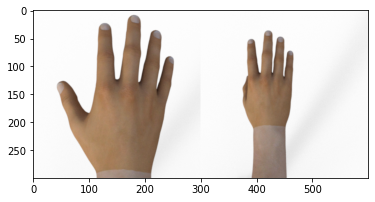

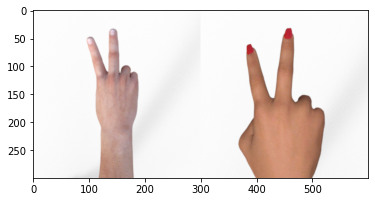

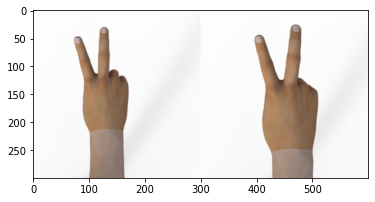

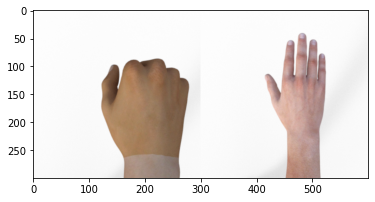

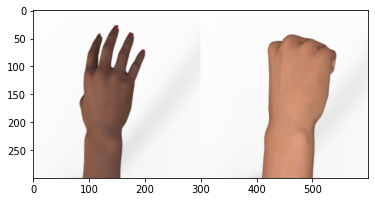

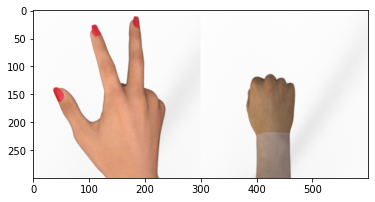

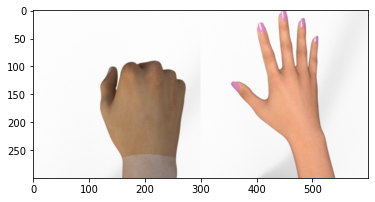

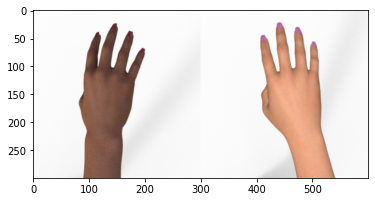

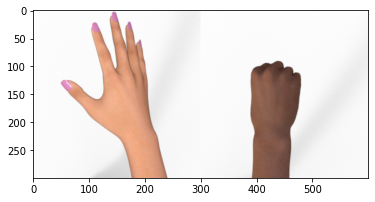

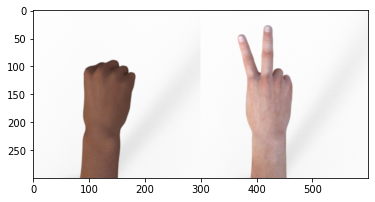

In [6]:
for i in range(10):
    plt.imshow(tdata[i])
    plt.show()

[0. 1. 0. 1. 0. 0.]
[[0, 'paper'], [1, 'rock'], [2, 'scissors']]


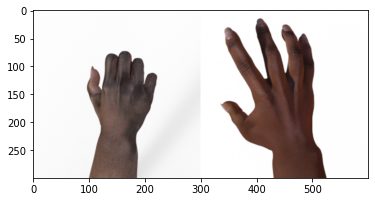

In [7]:
plt.imshow(data[250])
print(label[250])
print(categories)

In [8]:
print(data.shape)
print(label.shape)
print(tdata.shape)
print(tlabel.shape)

(1260, 300, 600, 3)
(1260, 6)
(186, 300, 600, 3)
(186, 6)


In [9]:
def create_model():
    
    #wydaje mi się że ta sieć jest dość mała 
    #większa ilość warstw lub filtrów prowadziła do 'overfitting'
    #zostawiłem parametry dla których osiągnąłem najlepsze wyniki
    model = keras.Sequential()
    model.add(RandomTranslation(0.02,0.02,input_shape=(300,600,3),
                               fill_mode="constant",fill_value=1,interpolation="bilinear"))
    model.add(RandomRotation(
        0.1,fill_mode="constant",interpolation="bilinear",fill_value=1))
    model.add(Conv2D(16,(4,4),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(32,(4,4),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(4,4),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(4,4),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))
    model.add(Conv2D(128,(4,4),activation='relu',padding='same'))
    model.add(MaxPool2D(pool_size=(3,3),strides=(3,3)))
    model.add(Flatten())
    #model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6,activation='sigmoid'))
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_translation (RandomTr (None, 300, 600, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 300, 600, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 600, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 200, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 200, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 200, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 66, 32)        0

In [10]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',metrics=['binary_accuracy','AUC','Precision','Recall'])

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'rps_model_acc.h5',save_best_only=True,
        monitor='val_binary_accuracy', mode='max'),
    keras.callbacks.ModelCheckpoint(
        'rps_model_auc.h5',save_best_only=True,
        monitor='val_auc', mode='max'),
    keras.callbacks.ModelCheckpoint(
        'rps_model_precision.h5',save_best_only=True,
        monitor='val_precision', mode='max'),
    keras.callbacks.ModelCheckpoint(
        'rps_model_recall.h5',save_best_only=True,
        monitor='val_recall', mode='max'),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss",factor=0.5,
        patience=3,verbose=1,
        mode="auto",min_delta=0.0001,
        cooldown=0,min_lr=0.0000000001,)
    #,
#    keras.callbacks.EarlyStopping(
#        monitor="val_loss",
#        min_delta=0,
#        patience=5,
#        verbose=1,
#        mode="auto",)
]

history = model.fit(data,label,batch_size=20,
                    epochs=50,validation_data=(tdata,tlabel),callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 10s 68ms/step - loss: 0.6470 - binary_accuracy: 0.6578 - auc: 0.4974 - precision: 0.3128 - recall: 0.0222 - val_loss: 0.6755 - val_binary_accuracy: 0.6667 - val_auc: 0.5193 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
63/63 [==============================] - 4s 58ms/step - loss: 0.6408 - binary_accuracy: 0.6669 - auc: 0.5076 - precision: 0.7500 - recall: 0.0012 - val_loss: 0.6641 - val_binary_accuracy: 0.6667 - val_auc: 0.5282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
63/63 [==============================] - 4s 58ms/step - loss: 0.6377 - binary_accuracy: 0.6672 - auc: 0.5208 - precision: 0.8333 - recall: 0.0020 - val_loss: 0.6440 - val_binary_accuracy: 0.6667 - val_auc: 0.6129 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
63/63 [==============================] - 3s 56ms/step - loss: 0.5987 - binary_accuracy: 0.6840 - auc: 0.6565 - precision: 0.6563 - recall: 0.1091 - val_loss:

63/63 [==============================] - 3s 53ms/step - loss: 0.0156 - binary_accuracy: 0.9950 - auc: 0.9998 - precision: 0.9944 - recall: 0.9905 - val_loss: 0.0100 - val_binary_accuracy: 0.9973 - val_auc: 1.0000 - val_precision: 1.0000 - val_recall: 0.9919
Epoch 32/50
63/63 [==============================] - 3s 53ms/step - loss: 0.0109 - binary_accuracy: 0.9968 - auc: 0.9998 - precision: 0.9960 - recall: 0.9944 - val_loss: 0.0273 - val_binary_accuracy: 0.9884 - val_auc: 0.9995 - val_precision: 0.9918 - val_recall: 0.9731
Epoch 33/50
63/63 [==============================] - 3s 52ms/step - loss: 0.0091 - binary_accuracy: 0.9963 - auc: 1.0000 - precision: 0.9944 - recall: 0.9944 - val_loss: 0.0354 - val_binary_accuracy: 0.9848 - val_auc: 0.9991 - val_precision: 0.9863 - val_recall: 0.9677
Epoch 34/50
63/63 [==============================] - 3s 52ms/step - loss: 0.0060 - binary_accuracy: 0.9983 - auc: 1.0000 - precision: 0.9976 - recall: 0.9972 - val_loss: 0.0213 - val_binary_accuracy: 0.

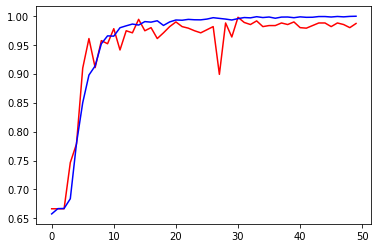

In [12]:
plt.plot(history.history['val_binary_accuracy'],color = 'red')
plt.plot(history.history['binary_accuracy'],color = 'blue')

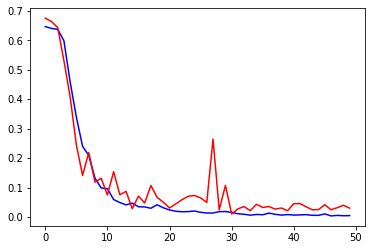

In [13]:
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='red')

In [14]:
#wczytanie wag dla najlepszego 'binnary accuracy'
model.load_weights('rps_model_acc.h5')

[4.1823159e-07 1.2190502e-06 9.9999928e-01 9.9921632e-01 1.1824899e-03
 1.3141293e-04]
left hand - scissors
right hand - paper


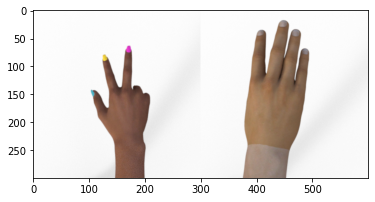

--------------------------------------------------
[1.00000000e+00 1.01342955e-07 9.83156738e-08 1.47216324e-05
 9.99996781e-01 3.62100900e-06]
left hand - paper
right hand - rock


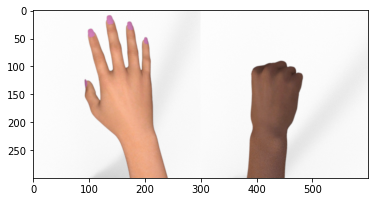

--------------------------------------------------
[2.3306751e-05 4.4762404e-05 9.9996448e-01 5.7125313e-04 5.6613784e-04
 9.9766684e-01]
left hand - scissors
right hand - scissors


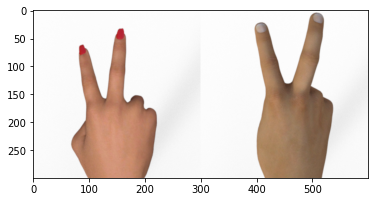

--------------------------------------------------
[9.8290438e-06 1.7738891e-04 9.9992466e-01 8.4237260e-04 6.7944969e-03
 9.7341037e-01]
left hand - scissors
right hand - scissors


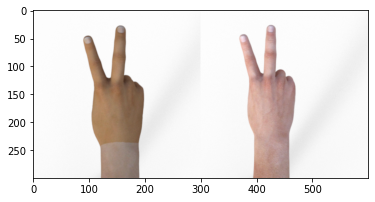

--------------------------------------------------
[1.5794237e-04 1.9138461e-05 9.9970394e-01 2.7467921e-05 9.9999988e-01
 1.8767491e-08]
left hand - scissors
right hand - rock


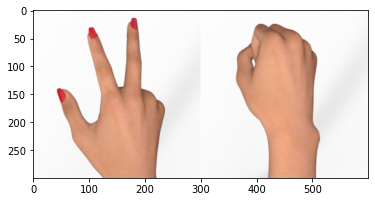

--------------------------------------------------
[1.0000000e+00 2.1616007e-08 3.3423884e-08 1.1461915e-06 9.9999976e-01
 2.1726437e-07]
left hand - paper
right hand - rock


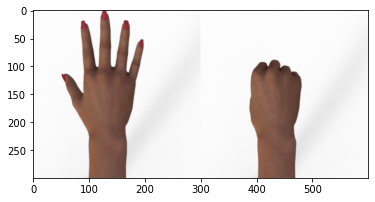

--------------------------------------------------
[9.9648547e-01 3.7153825e-04 2.1343252e-03 9.9999797e-01 1.8268907e-05
 3.3590327e-06]
left hand - paper
right hand - paper


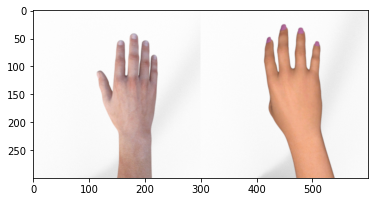

--------------------------------------------------
[9.9999881e-01 3.5357702e-05 2.3988578e-06 9.8988006e-04 3.2354565e-04
 9.9863786e-01]
left hand - paper
right hand - scissors


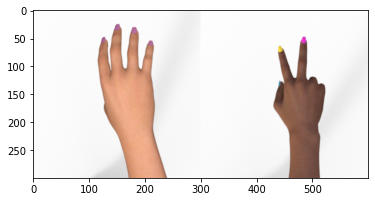

--------------------------------------------------
[9.9999774e-01 4.2698894e-06 3.2662756e-06 8.5485476e-01 4.5478428e-03
 4.6429224e-02]
left hand - paper
right hand - paper


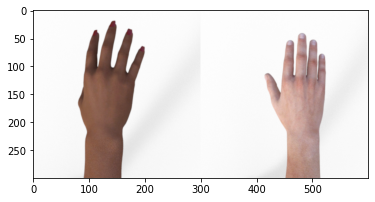

--------------------------------------------------
[9.9984562e-01 8.1906277e-05 6.9185808e-05 4.9304250e-05 9.9999523e-01
 2.7111439e-06]
left hand - paper
right hand - rock


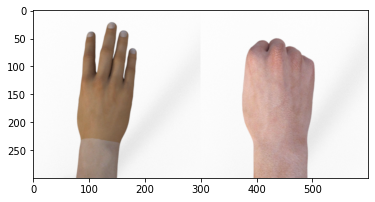

--------------------------------------------------


In [15]:
# sprawdzenie modelu na kilku wybranych zdjęciach
iii = [random.randint(0,186) for i in range (10)]
test_set = tdata[iii]
predictions = model.predict(test_set)
for i in range(len(test_set)):
    print(predictions[i])
    print(f'left hand - {categories[(np.argmax(predictions[i,0:3]))][1]}')
    print(f'right hand - {categories[(np.argmax(predictions[i,3:]))][1]}')
    plt.imshow(test_set[i])
    plt.show()

    
    print(50*'-')



In [16]:
#ewaluacja na zbiorze treningowym
print(model.evaluate(data,label))

40/40 [==============================] - 2s 42ms/step - loss: 1.1297e-04 - binary_accuracy: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000
[0.00011296517186565325, 1.0, 1.0, 1.0, 1.0]


In [17]:
#ewaluacja na zbiorze testowym
print(model.evaluate(tdata,tlabel))

6/6 [==============================] - 0s 75ms/step - loss: 0.0100 - binary_accuracy: 0.9973 - auc: 1.0000 - precision: 1.0000 - recall: 0.9919
[0.009986351244151592, 0.9973118305206299, 0.9999890923500061, 1.0, 0.9919354915618896]


Myślę że udało mi się osiągnąć dość dobre wyniki. Precyzja 1 oznacza, że jeśli model przewidział w którymś przypadku więcej niż 0.5 to zawsze było to poprawne. Zaczynam się obawiać, że jest coś o czym nie wiem i model jednak nie jest tak dobry
Metryka accuracy osiągała max 0.7, nie wiem czy źle działa dla multilabel. Na losowej próbie nie widać żeby model się tak mylił. Binary accuracy wyniosłoby 0.67 gdyby model wszędzie przewidywał 0, jednak osiągnęło prawie 1 także chyba dobrze.
Sieć nie jest najmniejsza ale zostawiłem tą ponieważ osiągała najlepsze wyniki. 
Mniejsza sieć wymagałaby przeskalowania wejściowych zdjeć do mniejszych rozmiarów. 